<a href="https://colab.research.google.com/github/tz15/CitadelDatathon/blob/main/team_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For training in colab 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/Colab Notebooks/Citadel/data

/content/drive/My Drive/Colab Notebooks/Citadel/data


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

pd.set_option('display.max_rows', None)

# PART I: Preparing Data

#### Loading the data

In [ ]:
country = pd.read_csv("country.csv")
league = pd.read_csv("league.csv")
match = pd.read_csv("match.csv")
player = pd.read_csv("player.csv")
player_attributes = pd.read_csv("player_attributes.csv")
team = pd.read_csv("team.csv", encoding='latin1')
team_attributes = pd.read_csv("team_attributes.csv")

#### Clean Date 

In [ ]:
match["date"] = match["date"].apply(lambda s: datetime.strptime(s, '%m/%d/%y %H:%M'))
player_attributes["date"] = player_attributes["date"].apply(lambda s: datetime.strptime(s, '%m/%d/%y %H:%M'))
team_attributes["date"] = team_attributes["date"].apply(lambda s: datetime.strptime(s, '%m/%d/%y %H:%M'))

#### Clean Duplicate Records

In [ ]:
match.drop_duplicates(subset=["match_id", "date"], inplace=True)
player_attributes.drop_duplicates(subset=["player_id", "date"], inplace=True)
team_attributes.drop_duplicates(subset=["team_id", "date"], inplace=True)

### Feature Engineering: Match and Team level

#### Join contry and league with team

In [ ]:
match = match.join(country.rename(columns = {"name":"country_name"}).set_index("country_id"), 
                   on = "country_id", how = "left")
match = match.join(league[["league_id","name"]].rename(columns = {"name":"league_name"}).set_index("league_id"), 
                   on = "league_id", how = "left")

#### Join Home and Away Team with Match

In [ ]:
match_team = match.join(team.set_index("team_id").rename(columns = {"team_long_name":"home_team_long_name",
                                                                    "team_short_name":"home_team_short_name"}),
                        on="home_team_id", how = "left")
match_team = match_team.join(team.set_index("team_id").rename(columns = {"team_long_name":"away_team_long_name",
                                                                         "team_short_name":"away_team_short_name"}),
                             on="away_team_id", how = "left")

#### Join Home and Away Team Attributes with Match
Note: 
1. Overall, the match the the most recently updated team attributes record. 
2. if the team has no attributes in history, it will be NA. 
3. if the match happened before the first team attributes record, it will get data from the first record.

In [ ]:
NOW_DAY = datetime(2021, 3, 23)

In [ ]:
# Join Home and Away Team with Match
team_attributes["next"] = team_attributes.groupby(['team_id'])["date"].rank() -1
team_attributes["now"] = team_attributes.groupby(['team_id'])["date"].rank()

In [ ]:
team_attributes_with_interval = team_attributes.merge(team_attributes[["team_id","next","date"]], 
                                                      left_on=["team_id","now"], 
                                                      right_on=["team_id","next"],
                                                      how = "left",
                                                      suffixes = ["", "_next"])

In [ ]:
team_attributes_with_interval["date_next"].fillna(NOW_DAY, inplace = True)
team_attributes_with_interval.drop(["next",  "next_next"], axis = 1, inplace= True)
# team_attributes_with_interval.head()

In [ ]:
# For home team attributes
match_team_and_attrs = match_team.merge(team_attributes_with_interval, 
                                        how="left",
                                        left_on = "home_team_id",
                                        right_on = "team_id",
                                        suffixes = ["", "_home_team"])
match_team_and_attrs = match_team_and_attrs[((match_team_and_attrs['date'] < match_team_and_attrs['date_next']) \
                                             & (match_team_and_attrs['date'] >= match_team_and_attrs['date_home_team'])) \
                                            |(match_team_and_attrs['date_home_team'].isnull()) \
                                            |((match_team_and_attrs['date'] < match_team_and_attrs['date_home_team']) \
                                             & (match_team_and_attrs['now'] == 1))  ]
match_team_and_attrs.drop(["team_id","now", "date_next"], axis = 1, inplace= True)                           

In [ ]:
# For away team attributes
match_team_and_attrs = match_team_and_attrs.merge(team_attributes_with_interval, 
                                                  how="left",
                                                  left_on = "away_team_id",
                                                  right_on = "team_id",
                                                  suffixes = ["", "_away_team"])
match_team_and_attrs = match_team_and_attrs[((match_team_and_attrs['date'] < match_team_and_attrs['date_next']) \
                                             & (match_team_and_attrs['date'] >= match_team_and_attrs['date_away_team'])) \
                                            |(match_team_and_attrs['date_away_team'].isnull()) \
                                            |((match_team_and_attrs['date'] < match_team_and_attrs['date_away_team']) \
                                             & (match_team_and_attrs['now'] == 1))  ]
match_team_and_attrs.drop(["team_id","now", "date_next"], axis = 1, inplace= True)                                                 

#### Add more match related features (New)

For the classification problem, we define a Home Win has label 2, Draw has label 1, and Home Loss has label 0, This choice is arbitrary.

In [ ]:
match_team_and_attrs["home_win"] = np.sign(match_team_and_attrs["home_team_goal"] - match_team_and_attrs["away_team_goal"])
match_team_and_attrs["home_win"] = match_team_and_attrs["home_win"].map({1:2,0:1,-1:0})
match_team_and_attrs["home_points"] = match_team_and_attrs["home_win"].map({2:3,1:1, 0:0})
match_team_and_attrs["away_points"] = match_team_and_attrs["home_win"].map({0:3,1:1, 2:0})
match_team_and_attrs.head()

,country_id,league_id,season,stage,date,match_id,home_team_id,away_team_id,home_team_goal,away_team_goal,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,...,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,date_away_team,buildUpPlaySpeed_away_team,buildUpPlaySpeedClass_away_team,buildUpPlayDribbling_away_team,buildUpPlayDribblingClass_away_team,buildUpPlayPassing_away_team,buildUpPlayPassingClass_away_team,buildUpPlayPositioningClass_away_team,chanceCreationPassing_away_team,chanceCreationPassingClass_away_team,chanceCreationCrossing_away_team,chanceCreationCrossingClass_away_team,chanceCreationShooting_away_team,chanceCreationShootingClass_away_team,chanceCreationPositioningClass_away_team,defencePressure_away_team,defencePressureClass_away_team,defenceAggression_away_team,defenceAggressionClass_away_team,defenceTeamWidth_away_team,defenceTeamWidthClass_away_team,defenceDefenderLineClass_away_team,home_win,home_points,away_points
0,1,1,2008/2009,1,2008-08-17,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,...,Organised,50.0,Normal,35.0,Normal,60.0,Normal,Organised,70.0,High,65.0,Press,70.0,Wide,Cover,2010-02-22,35.0,Balanced,NaN,Little,35.0,Mixed,Organised,45.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,70.0,Double,70.0,Wide,Cover,1,1,1
4,1,1,2008/2009,1,2008-08-16,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,...,Organised,60.0,Normal,40.0,Normal,50.0,Normal,Organised,70.0,High,60.0,Press,70.0,Wide,Cover,2010-02-22,60.0,Balanced,NaN,Little,60.0,Mixed,Organised,50.0,Normal,40.0,Normal,50.0,Normal,Organised,65.0,Medium,65.0,Press,70.0,Wide,Cover,1,1,1
10,1,1,2008/2009,1,2008-08-16,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,...,Organised,70.0,Risky,45.0,Normal,55.0,Normal,Organised,65.0,Medium,60.0,Press,70.0,Wide,Cover,2010-02-22,50.0,Balanced,NaN,Little,35.0,Mixed,Organised,70.0,Risky,50.0,Normal,60.0,Normal,Organised,70.0,High,50.0,Press,70.0,Wide,Cover,0,0,3
16,1,1,2008/2009,1,2008-08-17,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,...,Organised,60.0,Normal,50.0,Normal,60.0,Normal,Organised,45.0,Medium,50.0,Press,40.0,Normal,Cover,2012-02-22,50.0,Balanced,NaN,Little,50.0,Mixed,Organised,55.0,Normal,48.0,Normal,46.0,Normal,Organised,46.0,Medium,45.0,Press,47.0,Normal,Cover,2,3,0
19,1,1,2008/2009,1,2008-08-16,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010-02-22,53.0,Balanced,NaN,Little,40.0,Mixed,Organised,55.0,Normal,55.0,Normal,65.0,Normal,Organised,70.0,High,70.0,Double,65.0,Normal,Cover,0,0,3


Rolling average points get for previous 10 match at home or away, fillna with 1.5 by default

In [ ]:
ROLLING = 10
POINT_DEFAULT = 1.5

In [ ]:
match_team_and_attrs.sort_values("match_id", inplace=True)
match_team_and_attrs['__for_count'] = 1
team_season_metric_home = match_team_and_attrs.groupby(by = ["home_team_id"])[["home_points","__for_count"]]\
                                         .rolling(ROLLING, min_periods = 1).sum() \
                                         .reset_index()
team_season_metric_away = match_team_and_attrs.groupby(by = ["away_team_id"])[["away_points","__for_count"]]\
                                         .rolling(ROLLING, min_periods = 1).sum()\
                                         .reset_index()  
team_season_metric_home.rename(columns= {"home_points": "pre_home_points", "__for_count":"__for_count_home"},inplace=True)
team_season_metric_away.rename(columns={"away_points":"pre_away_points", "__for_count":"__for_count_away"},inplace=True)                               

In [ ]:
match_team_and_attrs.sort_values(["home_team_id","match_id"], inplace=True)
match_team_and_attrs.reset_index(drop = True, inplace= True)
match_team_and_attrs = match_team_and_attrs.join(team_season_metric_home[["pre_home_points", "__for_count_home"]])

match_team_and_attrs.sort_values(["away_team_id","match_id"], inplace=True)
match_team_and_attrs.reset_index(drop = True, inplace= True)
match_team_and_attrs = match_team_and_attrs.join(team_season_metric_away[["pre_away_points", "__for_count_away"]])

In [ ]:
match_team_and_attrs["pre_home_points_avg"] = (match_team_and_attrs["pre_home_points"] - match_team_and_attrs["home_points"]) / (match_team_and_attrs["__for_count_home"] - 1)
match_team_and_attrs["pre_away_points_avg"] = (match_team_and_attrs["pre_away_points"] - match_team_and_attrs["away_points"]) / (match_team_and_attrs["__for_count_away"] - 1)
match_team_and_attrs.drop(["__for_count", "pre_home_points", "pre_away_points","__for_count_home","__for_count_away"], axis = 1, inplace = True)

In [ ]:
match_team_and_attrs["pre_home_points_avg"] = match_team_and_attrs["pre_home_points_avg"].fillna(POINT_DEFAULT)
match_team_and_attrs["pre_away_points_avg"] = match_team_and_attrs["pre_away_points_avg"].fillna(POINT_DEFAULT)

### Feature Engineering: Match and Player Level

#### Join Play Attributes Metrics with Match (New, time consuming)

In [ ]:
player_attributes["next"] = player_attributes.groupby(['player_id'])["date"].rank() -1
player_attributes["now"] = player_attributes.groupby(['player_id'])["date"].rank()

player_with_interval = player_attributes.merge(player_attributes[["player_id","next","date"]], 
                                               left_on=["player_id","now"], 
                                               right_on=["player_id","next"],
                                               how = "left",
                                               suffixes = ["", "_next"])
player_with_interval["date_next"].fillna(NOW_DAY, inplace = True)
player_with_interval.drop(["next",  "next_next"], axis = 1, inplace= True)
# player_with_interval.head()

In [ ]:
player_columns = list(match_team_and_attrs.loc[:,'home_player_1':'away_player_11'].columns)
match_players_pre = match_team_and_attrs.loc[:, ["match_id", "date"] + player_columns]
match_players_pre = match_players_pre.melt(id_vars=["match_id", "date"])
match_players_pre.dropna(inplace=True)
match_players_pre["player_id"] = match_players_pre.value.astype(int)
# match_players_pre.head()

In [ ]:
# Combine the together
match_players  =  match_players_pre.merge(player_with_interval, 
                                          how="left",
                                          left_on = "player_id",
                                          right_on = "player_id",
                                          suffixes = ["", "_attr"])                    

In [ ]:
# Select based on right date
match_players = match_players[((match_players['date'] < match_players['date_next']) \
                                  & (match_players['date'] >= match_players['date_attr'])) \
                                |(match_players['date_attr'].isnull()) \
                                |((match_players['date'] < match_players['date_attr']) \
                                  & (match_players['now'] == 1))  ]
match_players.drop(["now", "date_next"], axis = 1, inplace= True)   

In [ ]:
match_players["variable"] = match_players["variable"].apply(lambda x: x[:4])

In [ ]:
def match_play_metric(x):
    names = {
        'player_overall_rating_max' : x['overall_rating'].max(),
        'player_overall_rating_avg': x['overall_rating'].mean(),
        'player_overall_rating_std':  x['overall_rating'].std(),
        'player_potential_max' : x['potential'].max(),
        'player_potential_avg': x['potential'].mean(),
        'player_potential_std':  x['potential'].std(),
        'gk_diving_max':  x['gk_diving'].max(),
        'short_passing_max':  x['short_passing'].max(),
        'finishing_max':  x['finishing'].max(),
        'crossing_max':  x['crossing'].max(),
        'marking_max':  x['marking'].max()
        }
    return pd.Series(names, index=["player_overall_rating_max", "player_overall_rating_avg", "player_overall_rating_std", 
                                   "player_potential_max", "player_potential_avg", "player_potential_std",
                                   'gk_diving_max','short_passing_max', 'finishing_max', 'crossing_max', 'marking_max' ])

In [ ]:
# Calculate the metric based on metric
match_players_metrics = match_players.groupby(["match_id","variable"]).apply(match_play_metric).reset_index()
# match_players_metrics.head()

In [ ]:
match_players_metrics.head()

In [ ]:
match_players_metrics_home = match_players_metrics[match_players_metrics['variable'] == "home"]
match_players_metrics_away = match_players_metrics[match_players_metrics['variable'] == "away"]
match_players_metrics_home.drop("variable", axis = 1, inplace = True)
match_players_metrics_away.drop("variable", axis = 1, inplace = True)
match_players_metrics_home.set_index("match_id", inplace = True)
match_players_metrics_away.set_index("match_id", inplace = True)

In [ ]:
# Join back to match_team_and_attrs
match_team_and_attrs = match_team_and_attrs.join(match_players_metrics_home, on = "match_id", how = "left")
match_team_and_attrs = match_team_and_attrs.join(match_players_metrics_away, on = "match_id", how = "left", rsuffix = '_away')

### Feature Enginnering: Match level

In [ ]:
match_team_and_attrs.drop(match_team_and_attrs.loc[:,'home_player_1':'away_player_11'],axis=1,inplace=True)
# match_team_and_attrs.head()
# match_team_and_attrs.columns
# match_team_and_attrs.shape
# match_team_and_attrs.isna().sum()

Defining the columns corresponding to mean bookmakers bets on home wins, away wins and draws


In [ ]:
home=['B365H','BWH','IWH','LBH','PSH','WHH','SJH','VCH','GBH','BSH']
away=['B365A','BWA','IWA','LBA','PSA','WHA','SJA','VCA','GBA','BSA']
draw=['B365D','BWD','IWD','LBD','PSD','WHD','SJD','VCD','GBD','BSD']
match_team_and_attrs['MBOH']=match_team_and_attrs[home].mean(axis=1)
match_team_and_attrs['MBOA']=match_team_and_attrs[away].mean(axis=1)
match_team_and_attrs['MBOD']=match_team_and_attrs[draw].mean(axis=1)
match_team_and_attrs['SBOH']=match_team_and_attrs[home].std(axis=1)
match_team_and_attrs['SBOA']=match_team_and_attrs[away].std(axis=1)
match_team_and_attrs['SBOD']=match_team_and_attrs[draw].std(axis=1)


Drop 2 columns where more than a half values is nan

In [ ]:
match_team_and_attrs.drop(['buildUpPlayDribbling','buildUpPlayDribbling_away_team'],axis=1,inplace=True)

In [ ]:
# match_team_and_attrs.head()

# PART II: EDA (Exploratory Data Analysis)

### What's the trends in home win compared with season

In [ ]:
import seaborn as sns

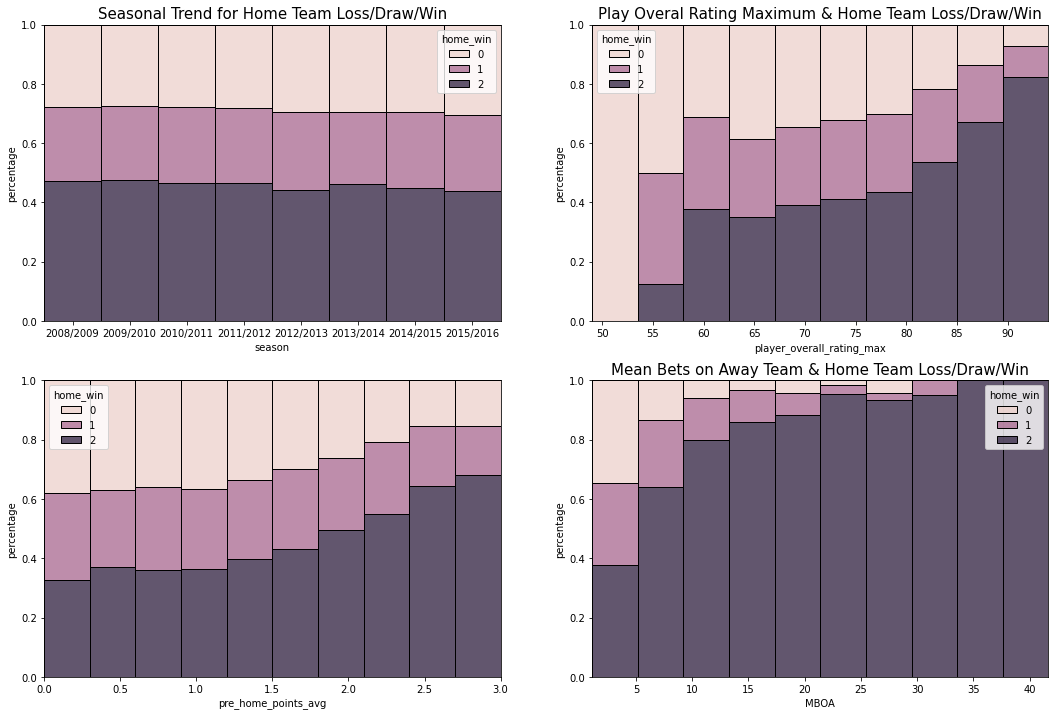

In [ ]:
fig, axes = plt.subplots(2,2, figsize = (18, 12)) 
sns.histplot(match_team_and_attrs, x="season", hue="home_win", multiple="fill", ax=axes[0][0])
sns.histplot(match_team_and_attrs, x="player_overall_rating_max", hue="home_win", bins=10,  multiple="fill", pthresh=.05, pmax=.9,ax=axes[0][1])
sns.histplot(match_team_and_attrs, x="pre_home_points_avg", hue="home_win", bins=10,  multiple="fill", pthresh=.05, pmax=.9,ax=axes[1][0])
sns.histplot(match_team_and_attrs, x="MBOA", hue="home_win", bins=10,  multiple="fill", pthresh=.05, pmax=.9,ax=axes[1][1])


axes[0][0].set_ylabel("percentage") 
axes[0][1].set_ylabel("percentage") 
axes[1][0].set_ylabel("percentage") 
axes[1][1].set_ylabel("percentage") 
axes[0][0].set_title("Seasonal Trend for Home Team Loss/Draw/Win", fontsize=15) 
axes[0][1].set_title("Play Overal Rating Maximum & Home Team Loss/Draw/Win", fontsize=15) 
axes[1][1].set_title("Home Team Historical Home Points & Home Team Loss/Draw/Win", fontsize=15) 
axes[1][1].set_title("Mean Bets on Away Team & Home Team Loss/Draw/Win", fontsize=15) 
plt.show()

### Are there relations between our features and match outcome?

In [ ]:
teamclasses = ['buildUpPlaySpeed', 'buildUpPlaySpeedClass',
                'buildUpPlayDribblingClass', 'buildUpPlayPassing',
                'buildUpPlayPassingClass', 'buildUpPlayPositioningClass',
                'chanceCreationPassing', 'chanceCreationPassingClass',
                'chanceCreationCrossing', 'chanceCreationCrossingClass',
                'chanceCreationShooting', 'chanceCreationShootingClass',
                'chanceCreationPositioningClass', 'defencePressure',
                'defencePressureClass', 'defenceAggression', 'defenceAggressionClass',
                'defenceTeamWidth', 'defenceTeamWidthClass', 'defenceDefenderLineClass',
                'date_away_team', 'buildUpPlaySpeed_away_team',
                'buildUpPlaySpeedClass_away_team',
                'buildUpPlayDribblingClass_away_team', 'buildUpPlayPassing_away_team',
                'buildUpPlayPassingClass_away_team',
                'buildUpPlayPositioningClass_away_team',
                'chanceCreationPassing_away_team',
                'chanceCreationPassingClass_away_team',
                'chanceCreationCrossing_away_team',
                'chanceCreationCrossingClass_away_team',
                'chanceCreationShooting_away_team',
                'chanceCreationShootingClass_away_team',
                'chanceCreationPositioningClass_away_team', 'defencePressure_away_team',
                'defencePressureClass_away_team', 'defenceAggression_away_team',
                'defenceAggressionClass_away_team', 'defenceTeamWidth_away_team',
                'defenceTeamWidthClass_away_team', 'defenceDefenderLineClass_away_team',
                "pre_home_points_avg",	"pre_away_points_avg",	
                
                "player_overall_rating_max",	"player_overall_rating_std",
                "gk_diving_max",	"short_passing_max",	"finishing_max",	"crossing_max",	"marking_max",
                "player_overall_rating_max_away",	"player_overall_rating_std_away",
                "gk_diving_max_away",	"short_passing_max_away",	"finishing_max_away",	"crossing_max_away",	"marking_max_away",

                # "player_overall_rating_avg"
                # "player_potential_max",	 "player_potential_avg", "player_potential_std",
                # "player_overall_rating_avg_away"
                # "player_potential_max_away",	 "player_potential_avg_away","player_potential_std_away",
                "MBOH",	"MBOA", "MBOD",
                "SBOH",	"SBOA",
                "SBOD"
                ]

In [ ]:
match_team_and_attrs.sort_values("match_id").reset_index(drop=True, inplace=True)
# match_team_and_attrs.head()

In [ ]:
features = match_team_and_attrs[teamclasses]

In [ ]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
features_num=features.select_dtypes(include=numerics)
features_num['home_win']=match_team_and_attrs['home_win']
f, ax1 = plt.subplots(1, 1, figsize=(10,10))
corr = features_num.corr()
sns.heatmap(corr, annot_kws={'size':10}, ax=ax1)
ax1.set_title('Correlation b/w features', fontsize=14)
plt.show()

Classification Model for home points and home win 
Whole data 
predict odds ? 

Two models 1) predict home win

2) predict mean book odds on home win 

In [ ]:
# match_team_and_attrs.head()

# PART III: Random Selected Train/Valid/Test, Model Investigations
Note: this part not include team's previous perfomance feature, which is related with time and not independent.

## Model Investigations

### 1) NN Classifer - No Longer Used

#### Set up Enviornment - run on GPU

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(torch.cuda.get_device_name(0))

In [ ]:
D_in = features_num.shape[1]-2
H1 = 1024
H2 = 512
H3 = 64
D_out = 3

In [ ]:
y = features_num['home_win']
y = y.fillna(1)

In [ ]:
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state = 12)

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

In [ ]:
epochs = 50
bs = 2500
lr = 1e-3
dtype = torch.float

In [ ]:
class teamData(Dataset):
  def __init__(self,X_data,y_data):
        self.X_data = X_data
        self.y_data = y_data
  def __getitem__(self, index):
      return self.X_data[index,:], self.y_data[index]
  def __len__(self):
      return len(self.X_data)

In [ ]:
train_dataset = teamData(torch.from_numpy(X_train).float(),torch.from_numpy(y_train).long())
val_dataset = teamData(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).long())
test_dataset = teamData(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).long())

In [ ]:
train_loader = DataLoader(dataset=train_dataset,batch_size=bs)
val_loader = DataLoader(dataset=val_dataset, batch_size=bs)
test_loader = DataLoader(dataset=test_dataset, batch_size=bs)

In [ ]:
class gameClassifier(nn.Module):
    def __init__(self):
        super(gameClassifier, self).__init__()
        self.layer_1 = nn.Linear(D_in, H1)
        self.layer_2 = nn.Linear(H1, H2)
        self.layer_3 = nn.Linear(H2,H3)
        self.layer_out = nn.Linear(H3, D_out) 
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(H1)
        self.batchnorm2 = nn.BatchNorm1d(H2)
        self.batchnorm3 = nn.BatchNorm1d(H3)

        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_3(x)
        x = self.batchnorm3(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.layer_out(x)
        
        return x

In [ ]:
model = gameClassifier()
model.to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr,momentum=.9)

In [ ]:
trainLossArr = []
valLossArr = [] 
trainAccArr = []
valAccArr = []
for e in tqdm(range(1, epochs+1)):
    # TRAINING of model
    train_epoch_loss = 0
    total = 0
    correct = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device) #send batches to device
        y_train_pred = model(X_train_batch) #use model to classify
        train_loss = criterion(y_train_pred, y_train_batch) #compute loss
        train_loss.backward() #compute gradient
        optimizer.step() 
        train_epoch_loss += train_loss.item()
        #print(train_loss.item())
        _, y_train_pred_tag = torch.max(y_train_pred.data,dim=1) #take maximum activation and use this as the predicted value
        y_train_batch.data
        correct_tag = y_train_batch.data #obtain the correct value
        total += y_train_batch.size(0)
        correct += (y_train_pred_tag == correct_tag).sum().item()
    epochAcc = correct/total *100
    trainAccArr.append(epochAcc)
    trainLossArr.append(train_epoch_loss/total)
    print("TRAIN: Epoch: {}, Class: {}, Prediction: {}, Accuracy: {}".format(e,correct_tag,y_train_pred_tag,epochAcc))
        # VALIDATION of model
    with torch.no_grad():
        val_epoch_loss = 0
        total = 0
        correct = 0
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            val_loss = criterion(y_val_pred, y_val_batch)
            val_epoch_loss += val_loss.item()
            _, y_val_pred_tag = torch.max(y_val_pred.data,dim=1)
            correct_val = y_val_batch.data
            total += y_val_batch.size(0)
            correct += (y_val_pred_tag == correct_val).sum().item()
        valAcc = correct/total*100
        valAccArr.append(valAcc)
        valLossArr.append(val_epoch_loss/total)
        print("VALIDATE: Class: {}, Prediction: {}, Accuracy: {}".format(correct_val,y_val_pred_tag,valAcc))

In [ ]:
ep1 = np.linspace(0,epochs,len(trainLossArr))
print(trainLossArr)
ep2 = np.linspace(0,epochs,len(valLossArr))
plt.clf()
plt.plot(ep1,trainLossArr,'r-',label="Training Loss")
plt.plot(ep2,valLossArr,'b-',label="Validation Loss")
plt.title("Loss vs. Epoch")
plt.legend(loc="best")
plt.show()

In [ ]:
#Test the data on the excluded dataset
y_pred_list = []
X_test_list = []
y_pred = []
numcorrect = 0
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        _,y_pred_tags = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tags.cpu().numpy().astype(int))


for arr in y_pred_list:
  for el in arr:
    y_pred.append(el)

for i in range(len(y_test)):
  if y_test[i] == y_pred[i]:
          numcorrect += 1
accuracy = numcorrect/len(y_test) *100

print("Acccuracy: {} %".format(accuracy))

#### Cross Validation


##### Since this is in the same notebook, completley reload all variables to show that it is an independent test

In [ ]:
if(torch.cuda.is_available()):
    device = torch.device("cuda:0")
else:
  device = torch.device("cpu")
print(torch.cuda.get_device_name(0))

In [ ]:
X = features_num.iloc[:,0:-2]
X = X.fillna(0)

In [ ]:
X.shape

In [ ]:
y = features_num['home_win']
y = y.fillna(1)

In [ ]:
y.shape

In [ ]:
D_in = features_num.shape[1]-2
H1 = 300
H2 = 64
D_out = 3

In [ ]:
scaler = MinMaxScaler()
X_for_fold = scaler.fit_transform(X)
X_fold_non, y_fold_non = np.array(X_for_fold),np.array(y) #non shuffled
#create random shuffeler to permuatate both x and y data
shuffler = np.random.permutation(len(X_fold_non))
X_fold, y_fold = X_fold_non[shuffler],y_fold_non[shuffler] #shuffled

In [ ]:
epochs = 50
bs = 2500
lr = 1e-4
dtype = torch.float
total_fold = 10


In [ ]:
class teamData(Dataset):
  def __init__(self,X_data,y_data):
        self.X_data = X_data
        self.y_data = y_data
  def __getitem__(self, index):
      return self.X_data[index,:], self.y_data[index]
  def __len__(self):
      return len(self.X_data)

In [ ]:
fold_dataset = teamData(torch.from_numpy(X_fold).float(),torch.from_numpy(y_fold).long())

In [ ]:
class gameClassifier(nn.Module):
    def __init__(self):
        super(gameClassifier, self).__init__()
        
        self.layer_1 = nn.Linear(D_in, H1)
        self.layer_2 = nn.Linear(H1, H2)
        self.layer_out = nn.Linear(H2, D_out) 
        
        self.relu = nn.ReLU()
        #self.dropout = nn.Dropout(p=0.2)
        self.batchnorm1 = nn.BatchNorm1d(H1)
        self.batchnorm2 = nn.BatchNorm1d(H2)
        
    def forward(self, x):
        x = self.layer_1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        
        x = self.layer_2(x)
        x = self.batchnorm2(x)  
        x = self.relu(x)
        #x = self.dropout(x)
                
        x = self.layer_out(x)
        
        return x

In [ ]:
fold_test_acc = []
fold_train_acc = []
train_score = []
test_score = []
total_size = len(y_fold) #size of dataset
fold_size = int(total_size * (1/total_fold)) #size of each fold dataset
for i in range(total_fold):
    train_left_low = 0 #create indexes to bound the lower training set folds
    train_left_high = i*fold_size
    test_low = train_left_high #create indexes to bound the holdout fold
    test_high = i*fold_size + fold_size 
    train_right_low = test_high #create indexes to bound upper training set folds
    train_right_high = total_size
    print("Fold: {}, Training At: ({},{}), ({},{}) Testing At: ({},{})".format(i,train_left_low,train_left_high,train_right_low,train_right_high,test_low,test_high))
    train_left_idx = list(range(train_left_low,train_left_high))
    train_right_idx = list(range(train_right_low,train_right_high))
    train_idx = train_left_idx + train_right_idx
    
    test_idx = list(range(test_low,test_high))
    
    train_dataset = torch.utils.data.dataset.Subset(fold_dataset,train_idx)
    test_dataset = torch.utils.data.dataset.Subset(fold_dataset,test_idx)
    
    print(len(train_dataset),len(test_dataset))
    
    train_fold_loader = torch.utils.data.DataLoader(train_dataset,batch_size=bs)
    test_fold_loader = torch.utils.data.DataLoader(test_dataset,batch_size=bs)
    model = gameClassifier()
    model.to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    for e in tqdm(range(1, epochs+1)):
        trainAccArr = []
        trainLossArr = []
        train_epoch_loss = 0
        total = 0
        correct = 0
        model.train()
        for X_train_batch, y_train_batch in train_fold_loader:
            X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
            y_train_pred = model(X_train_batch)
            train_loss = criterion(y_train_pred, y_train_batch)
            train_loss.backward()
            optimizer.step()
            train_epoch_loss += train_loss.item()
            _, y_train_pred_tag = torch.max(y_train_pred.data,dim=1)
            correct_tag = y_train_batch.data
            total += y_train_batch.size(0)
            correct += (y_train_pred_tag == correct_tag).sum().item()
        epochAcc = correct/total *100
        print("Train Acc: {}".format(epochAcc))
        trainAccArr.append(epochAcc)
        trainLossArr.append(train_epoch_loss/total)
        train_score.append(trainAccArr[0])
    with torch.no_grad():
        val_epoch_loss = 0
        total = 0
        correct = 0
        valAccArr = []
        valLossArr = []
        model.eval()
        for X_val_batch, y_val_batch in test_fold_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            y_val_pred = model(X_val_batch)
            _, y_val_pred_tag = torch.max(y_val_pred.data,dim=1)
            correct_val = y_val_batch.data
            total += y_val_batch.size(0)
            print(y_val_pred_tag,correct_val)
            correct += (y_val_pred_tag == correct_val).sum().item()
        valAcc = correct/total*100
        valAccArr.append(valAcc)
        print("Test Acc: {}".format(valAcc))
        valLossArr.append(val_epoch_loss/total)
        test_score.append(valAccArr[0])

for i in range(total_fold):
    l = i*10
    r = l+10
    
    sumTrain = sum(train_score[l:r])
    fold_train_acc.append(sumTrain/total_fold)

final_train_accuracy = sum(fold_train_acc)/total_fold
final_test_accuracy = sum(test_score)/total_fold
print("Cross Validation Results")
print("Training Accuracy: {}".format(final_train_accuracy))
print("Testing Accuracy: {}".format(final_test_accuracy))

In [ ]:
testAcc = np.linspace(0,total_fold,len(test_score))
trainAcc = np.linspace(0,total_fold,len(fold_train_acc))
plt.clf()
plt.plot(testAcc,test_score,'r-',label="Testing Accuracy")
plt.plot(trainAcc,fold_train_acc,'b-',label = "Training Accuracy")
plt.legend(loc="best")
plt.title("Accuracy vs Fold")
plt.show()

### 2) Other Model Investigations


In [ ]:
X = features_num.iloc[:,0:-2]
from sklearn.impute import SimpleImputer
imputer=SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X),columns=features_num.iloc[:,0:-2].columns)
X.head()

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,buildUpPlaySpeed_away_team,buildUpPlayPassing_away_team,chanceCreationPassing_away_team,chanceCreationCrossing_away_team,chanceCreationShooting_away_team,defencePressure_away_team,defenceAggression_away_team,defenceTeamWidth_away_team,pre_home_points_avg,pre_away_points_avg,player_overall_rating_max,player_overall_rating_std,gk_diving_max,short_passing_max,finishing_max,crossing_max,marking_max,player_overall_rating_max_away,player_overall_rating_std_away,gk_diving_max_away,short_passing_max_away,finishing_max_away,crossing_max_away,marking_max_away,MBOH,MBOA,MBOD,SBOH,SBOA
0,40.0,35.0,55.0,35.0,70.0,70.0,70.0,65.0,30.0,40.0,50.0,35.0,70.0,65.0,60.0,50.0,1.50,1.500000,77.0,3.443043,74.0,78.0,76.0,76.0,76.0,77.0,3.464102,74.0,78.0,76.0,76.0,76.0,2.122222,3.422222,3.401429,0.056821,0.172321
1,30.0,50.0,45.0,35.0,70.0,60.0,70.0,55.0,30.0,40.0,50.0,35.0,70.0,65.0,60.0,50.0,0.00,0.000000,64.0,3.674235,64.0,60.0,69.0,65.0,62.0,59.0,2.753785,45.0,64.0,49.0,64.0,60.0,2.122222,3.422222,3.401429,0.056821,0.172321
2,30.0,45.0,45.0,40.0,70.0,70.0,70.0,65.0,30.0,40.0,50.0,35.0,70.0,65.0,60.0,50.0,1.50,0.500000,77.0,3.443043,74.0,78.0,76.0,76.0,76.0,77.0,3.464102,74.0,78.0,76.0,76.0,76.0,2.122222,3.422222,3.401429,0.056821,0.172321
3,30.0,40.0,45.0,40.0,70.0,55.0,65.0,55.0,30.0,40.0,50.0,35.0,70.0,65.0,60.0,50.0,2.00,0.333333,77.0,3.443043,74.0,78.0,76.0,76.0,76.0,77.0,3.464102,74.0,78.0,76.0,76.0,76.0,2.122222,3.422222,3.401429,0.056821,0.172321
4,30.0,50.0,45.0,40.0,70.0,65.0,70.0,65.0,30.0,40.0,50.0,35.0,70.0,65.0,60.0,50.0,1.75,0.250000,77.0,3.443043,74.0,78.0,76.0,76.0,76.0,77.0,3.464102,74.0,78.0,76.0,76.0,76.0,2.122222,3.422222,3.401429,0.056821,0.172321


In [ ]:
y = features_num['home_win']
y = y.fillna(1)

Try simple baseline logistic

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=42)
scaler=StandardScaler()
scaler.fit_transform(Xtrain)
scaler.transform(Xtest)
log_reg=LogisticRegression(solver='saga',max_iter=10000)
log_reg.fit(Xtrain,ytrain)
log_reg_pred_train=log_reg.predict(Xtrain)
log_reg_pred_test=log_reg.predict(Xtest)
print("In sample accuracy baseline logistic: ", accuracy_score(log_reg_pred_train,ytrain))
print("Out of sample accuracy baseline logistic: ", accuracy_score(log_reg_pred_test,ytest))

In sample accuracy baseline logistic:  0.5249001587836212
Out of sample accuracy baseline logistic:  0.5271362586605081


Baseline SVC

In [ ]:
from sklearn.svm import SVC
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=4)
scaler=StandardScaler()
scaler.fit_transform(Xtrain)
scaler.transform(Xtest)
svc=SVC()
svc.fit(Xtrain, ytrain)
svc_pred_train=svc.predict(Xtrain)
svc_pred_test=svc.predict(Xtest)
print("In sample accuracy baseline SVC: ", accuracy_score(svc_pred_train,ytrain))
print("Out of sample accuracy baseline SVC: ", accuracy_score(svc_pred_test,ytest))

In sample accuracy baseline SVC:  0.5170572102198913
Out of sample accuracy baseline SVC:  0.5082755966127791


Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=3)
scaler=StandardScaler()
scaler.fit_transform(Xtrain)
scaler.transform(Xtest)
rf=RandomForestClassifier(n_estimators=1000,max_depth=7)
rf.fit(Xtrain, ytrain)
rf_pred_train=rf.predict(Xtrain)
rf_pred_test=rf.predict(Xtest)
print("In sample accuracy baseline RF: ", accuracy_score(rf_pred_train,ytrain))
print("Out of sample accuracy baseline RF: ", accuracy_score(rf_pred_test,ytest))

In sample accuracy baseline RF:  0.5365924072559304
Out of sample accuracy baseline RF:  0.5173210161662818


Compare Models with Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
print(confusion_matrix(rf_pred_test,ytest))

[[ 657  336  321]
 [   0    0    0]
 [ 823 1028 2031]]


In [ ]:
print(confusion_matrix(svc_pred_test,ytest))

[[ 278  211  380]
 [   0    0    0]
 [1202 1153 1972]]


In [ ]:
print(confusion_matrix(log_reg_pred_test,ytest))

[[ 366  334  581]
 [   0    1    4]
 [1114 1029 1767]]


In [ ]:
y.value_counts()

2    11917
0     7466
1     6596
Name: home_win, dtype: int64

## Feature Investigations



### 1)Add in Betting Info as features in X 

#### See if we can create a smart betting algortihm (53%)

Add the mean betting scores defined previously to the feautures matrix


In [ ]:
bets=match_team_and_attrs[['MBOH','MBOA','MBOD']]
print(bets.head())
print(X.head())

   MBOH  MBOA  MBOD
0   NaN   NaN   NaN
1   NaN   NaN   NaN
2   NaN   NaN   NaN
3   NaN   NaN   NaN
4   NaN   NaN   NaN
   buildUpPlaySpeed  buildUpPlayPassing  ...      SBOH      SBOA
0              40.0                35.0  ...  0.056821  0.172321
1              30.0                50.0  ...  0.056821  0.172321
2              30.0                45.0  ...  0.056821  0.172321
3              30.0                40.0  ...  0.056821  0.172321
4              30.0                50.0  ...  0.056821  0.172321

[5 rows x 37 columns]


In [ ]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=1)
scaler=StandardScaler()
scaler.fit_transform(Xtrain)
scaler.transform(Xtest)
svc.fit(Xtrain, ytrain)
svc_pred_train=svc.predict(Xtrain)
svc_pred_test=svc.predict(Xtest)
print("In sample accuracy baseline SVC with mean bets added: ", accuracy_score(svc_pred_train,ytrain))
print("Out of sample accuracy baseline SVC with mean bets added: ", accuracy_score(svc_pred_test,ytest))

In sample accuracy baseline SVC with mean bets added:  0.5162873502381754
Out of sample accuracy baseline SVC with mean bets added:  0.5130869899923017


In [ ]:
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=3)
scaler=StandardScaler()
scaler.fit_transform(Xtrain)
scaler.transform(Xtest)
rf.fit(Xtrain, ytrain)
rf_pred_train=rf.predict(Xtrain)
rf_pred_test=rf.predict(Xtest)
print("In sample accuracy baseline RF with mean bets added: ", accuracy_score(rf_pred_train,ytrain))
print("Out of sample accuracy baseline RF with mean bets added: ", accuracy_score(rf_pred_test,ytest))

In sample accuracy baseline RF with mean bets added:  0.5374103834865034
Out of sample accuracy baseline RF with mean bets added:  0.5177059276366436


In [ ]:
predicted_probs_rf=pd.DataFrame(rf.predict_proba(Xtest))
predicted_probs_rf.head()

,0,1,2
0,0.177126,0.243269,0.579606
1,0.360827,0.290595,0.348578
2,0.413595,0.271119,0.315286
3,0.268766,0.288980,0.442254
4,0.233346,0.276993,0.489660


In [ ]:
print("Out-of sample precision: ", precision_score(rf_pred_test,ytest,average='weighted'))
print("Out-of sample recall: ",recall_score(rf_pred_test,ytest,average='weighted'))

Out-of sample precision:  0.7570416940364978
Out-of sample recall:  0.5177059276366436


Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.


# PART IV: Time Based Train/Valid/Test, Model Investigations

## 1. Prepare train, validation, test set

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
teams_class_cols = ['buildUpPlaySpeed', 'buildUpPlayPassing', 'chanceCreationPassing',
                    'chanceCreationCrossing', 'chanceCreationShooting', 'defencePressure',
                    'defenceAggression', 'defenceTeamWidth', 'buildUpPlaySpeed_away_team',
                    'buildUpPlayPassing_away_team', 'chanceCreationPassing_away_team',
                    'chanceCreationCrossing_away_team', 'chanceCreationShooting_away_team',
                    'defencePressure_away_team', 'defenceAggression_away_team',
                    'defenceTeamWidth_away_team']
team_performance_cols = ["pre_home_points_avg",	"pre_away_points_avg"]
players_cols = ["player_overall_rating_max",	"player_overall_rating_std",
                "gk_diving_max",	"short_passing_max",	"finishing_max",	"crossing_max",	"marking_max",
                "player_overall_rating_max_away",	"player_overall_rating_std_away",
                "gk_diving_max_away",	"short_passing_max_away",	"finishing_max_away",	"crossing_max_away",	"marking_max_away"]
bets_cols = ["MBOH",	"MBOA","MBOD", "SBOH",	"SBOA"]
others = ['league_id']

features_cols = teams_class_cols + team_performance_cols + players_cols + bets_cols + others

In [ ]:
X_pre = match_team_and_attrs[features_cols]
X_pre_median = X_pre.median(axis = 0, numeric_only=True)
X_pre.fillna(X_pre_median, inplace=True)
data = X_pre.join(match_team_and_attrs[["home_win", "season"]])

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
VALIDATION_SEASON = "2014/2015"
TEST_SEASON = "2015/2016"

In [ ]:
test_idx = data.season == TEST_SEASON
print('testing percentage:{:.3f}'.format((test_idx).sum() / len(data.season)))

valid_idx = data.season == VALIDATION_SEASON
print('validation percentage:{:.3f}'.format((valid_idx).sum() / len(data.season)))
data.drop('season', axis = 1, inplace = True)

testing percentage:0.128
validation percentage:0.128


In [ ]:
# from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## 2. Feature Investigations using Random Forests

### Model 0.1: Only Team Attributes

In [ ]:
data_filtered = data[teams_class_cols + ['home_win']]

train_df = data_filtered[(test_idx == False) & (valid_idx == False)]
valid_df = data_filtered[valid_idx == True]

train_valid_df = data_filtered[(test_idx == False)]
test_df = data_filtered[test_idx == True]


X_train = train_df.drop('home_win', axis = 1)
y_train = train_df['home_win']

X_valid = valid_df.drop('home_win', axis = 1)
y_valid = valid_df['home_win']

X_train_valid = train_valid_df.drop('home_win', axis = 1)
y_train_valid = train_valid_df['home_win']

X_test = test_df.drop('home_win', axis = 1)
y_test = test_df['home_win']

rf_params = {'n_estimators': 377, 'max_depth': 6, 'min_samples_split': 7}
rf_model_filtered = RandomForestClassifier(**rf_params)
rf_model_filtered = rf_model_filtered.fit(X_train_valid, y_train_valid)
rf_model_filtered_train_valid=rf_model_filtered.predict(X_train_valid)
rf_model_filtered_test=rf_model_filtered.predict(X_test)
print("In sample accuracy tuned RF: ", accuracy_score(rf_model_filtered_train_valid,y_train_valid))
print("Testing accuracy tuned RF: ", accuracy_score(rf_model_filtered_test,y_test))

In sample accuracy tuned RF:  0.4836445503906767
Testing accuracy tuned RF:  0.45429945880938066


### Model 0.2: Team with Previous Performance 

In [ ]:
data_filtered = data[team_performance_cols + ['home_win']]


train_df = data_filtered[(test_idx == False) & (valid_idx == False)]
valid_df = data_filtered[valid_idx == True]

train_valid_df = data_filtered[(test_idx == False)]
test_df = data_filtered[test_idx == True]


X_train = train_df.drop('home_win', axis = 1)
y_train = train_df['home_win']

X_valid = valid_df.drop('home_win', axis = 1)
y_valid = valid_df['home_win']

X_train_valid = train_valid_df.drop('home_win', axis = 1)
y_train_valid = train_valid_df['home_win']

X_test = test_df.drop('home_win', axis = 1)
y_test = test_df['home_win']

rf_params = {'n_estimators': 377, 'max_depth': 6, 'min_samples_split': 7}
rf_model_filtered = RandomForestClassifier(**rf_params)
rf_model_filtered = rf_model_filtered.fit(X_train_valid, y_train_valid)
rf_model_filtered_train_valid=rf_model_filtered.predict(X_train_valid)
rf_model_filtered_test=rf_model_filtered.predict(X_test)
print("In sample accuracy tuned RF: ", accuracy_score(rf_model_filtered_train_valid,y_train_valid))
print("Testing accuracy tuned RF: ", accuracy_score(rf_model_filtered_test,y_test))

In sample accuracy tuned RF:  0.4990508983357613
Testing accuracy tuned RF:  0.4747444377630788


### Model 0.3: Match Players Attributes

In [ ]:
data_filtered = data[players_cols + ['home_win']]


train_df = data_filtered[(test_idx == False) & (valid_idx == False)]
valid_df = data_filtered[valid_idx == True]

train_valid_df = data_filtered[(test_idx == False)]
test_df = data_filtered[test_idx == True]


X_train = train_df.drop('home_win', axis = 1)
y_train = train_df['home_win']

X_valid = valid_df.drop('home_win', axis = 1)
y_valid = valid_df['home_win']

X_train_valid = train_valid_df.drop('home_win', axis = 1)
y_train_valid = train_valid_df['home_win']

X_test = test_df.drop('home_win', axis = 1)
y_test = test_df['home_win']

rf_params = {'n_estimators': 377, 'max_depth': 6, 'min_samples_split': 7}
rf_model_filtered = RandomForestClassifier(**rf_params)
rf_model_filtered = rf_model_filtered.fit(X_train_valid, y_train_valid)
rf_model_filtered_train_valid=rf_model_filtered.predict(X_train_valid)
rf_model_filtered_test=rf_model_filtered.predict(X_test)
print("In sample accuracy tuned RF: ", accuracy_score(rf_model_filtered_train_valid,y_train_valid))
print("Testing accuracy tuned RF: ", accuracy_score(rf_model_filtered_test,y_test))

In sample accuracy tuned RF:  0.5220500595947557
Testing accuracy tuned RF:  0.4927841250751654


### Model 0.4: Match Mean Bets

In [ ]:
data_filtered = data[bets_cols + ['home_win']]


train_df = data_filtered[(test_idx == False) & (valid_idx == False)]
valid_df = data_filtered[valid_idx == True]

train_valid_df = data_filtered[(test_idx == False)]
test_df = data_filtered[test_idx == True]


X_train = train_df.drop('home_win', axis = 1)
y_train = train_df['home_win']

X_valid = valid_df.drop('home_win', axis = 1)
y_valid = valid_df['home_win']

X_train_valid = train_valid_df.drop('home_win', axis = 1)
y_train_valid = train_valid_df['home_win']

X_test = test_df.drop('home_win', axis = 1)
y_test = test_df['home_win']

rf_params = {'n_estimators': 377, 'max_depth': 6, 'min_samples_split': 7}
rf_model_filtered = RandomForestClassifier(**rf_params)
rf_model_filtered = rf_model_filtered.fit(X_train_valid, y_train_valid)
rf_model_filtered_train_valid=rf_model_filtered.predict(X_train_valid)
rf_model_filtered_test=rf_model_filtered.predict(X_test)
print("In sample accuracy tuned RF: ", accuracy_score(rf_model_filtered_train_valid,y_train_valid))
print("Testing accuracy tuned RF: ", accuracy_score(rf_model_filtered_test,y_test))

In sample accuracy tuned RF:  0.5299960270162892
Testing accuracy tuned RF:  0.502705953096813


## 3. Model Investigations

### Model 1: Random Forests

In [ ]:
train_df = data[(test_idx == False) & (valid_idx == False)]
valid_df = data[valid_idx == True]

train_valid_df = data[(test_idx == False)]
test_df = data[test_idx == True]

bet_train_df= data[(test_idx==False)]


X_train = train_df.drop('home_win', axis = 1)
y_train = train_df['home_win']

X_valid = valid_df.drop('home_win', axis = 1)
y_valid = valid_df['home_win']

X_train_valid = train_valid_df.drop('home_win', axis = 1)
y_train_valid = train_valid_df['home_win']

X_test = test_df.drop('home_win', axis = 1)
y_test = test_df['home_win']

In [ ]:
'''
scaler_train=StandardScaler()
scaler_train.fit_transform(X_train)
X_train = scaler_train.transform(X_train)
X_valid = scaler_train.transform(X_valid)

scaler_evl=StandardScaler()
scaler_evl.fit_transform(X_train_valid)
X_train_valid = scaler_evl.transform(X_train_valid)
X_test = scaler_evl.transform(X_test)
'''

# scaler_evl.inverse_transform(X_test)

'\nscaler_train=StandardScaler()\nscaler_train.fit_transform(X_train)\nX_train = scaler_train.transform(X_train)\nX_valid = scaler_train.transform(X_valid)\n\nscaler_evl=StandardScaler()\nscaler_evl.fit_transform(X_train_valid)\nX_train_valid = scaler_evl.transform(X_train_valid)\nX_test = scaler_evl.transform(X_test)\n'

#### Training the model using grid search

In [ ]:
# rf_new=RandomForestClassifier(n_estimators=100,max_depth=7)
# rf_new.fit(X_train, y_train)
# rf_new_pred_train=rf_new.predict(X_train)
# rf_new_pred_test=rf_new.predict(X_valid)
# print("In sample accuracy baseline RF: ", accuracy_score(rf_new_pred_train,y_train))
# print("Out of sample accuracy baseline RF: ", accuracy_score(rf_new_pred_test,y_valid))

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
N_FOLDS = 4
other_params = {'n_estimators': 100,  'max_depth': 10, 'min_samples_split': 2}

In [ ]:
cv_params = {'n_estimators': np.linspace(10, 500, 5, dtype=int)}
rf_model = RandomForestClassifier(**other_params) 
rf_gs = GridSearchCV(rf_model, cv_params, verbose=2, refit=True, cv=N_FOLDS, n_jobs=4,scoring = 'accuracy')
rf_gs.fit(X_train, y_train)
other_params.update(rf_gs.best_params_)
rf_gs.best_params_,rf_gs.best_score_

In [ ]:
cv_params = {'max_depth': np.linspace(2, 10, 5, dtype=int)}
rf_model = RandomForestClassifier(**other_params) 
rf_gs = GridSearchCV(rf_model, cv_params, verbose=2, refit=True, cv=N_FOLDS, n_jobs=4,scoring = 'accuracy')
rf_gs.fit(X_train, y_train)
other_params.update(rf_gs.best_params_)
rf_gs.best_params_,rf_gs.best_score_

In [ ]:
cv_params = {'min_samples_split': np.linspace(1, 10, 5, dtype=int)}
rf_model = RandomForestClassifier(**other_params) 
rf_gs = GridSearchCV(rf_model, cv_params, verbose=2, refit=True, cv=N_FOLDS, n_jobs=4,scoring = 'accuracy')
rf_gs.fit(X_train, y_train)
other_params.update(rf_gs.best_params_)
rf_gs.best_params_,rf_gs.best_score_

#### Tuned model Performance on validation

In [ ]:
rf_params = {'n_estimators': 377, 'max_depth': 6, 'min_samples_split': 7}
rf_model_tuned = RandomForestClassifier(**rf_params)
rf_model_tuned = rf_model_tuned.fit(X_train, y_train)
rf_model_tuned_train=rf_model_tuned.predict(X_train)
rf_model_tuned_valid=rf_model_tuned.predict(X_valid)
print("In sample accuracy tuned RF: ", accuracy_score(rf_model_tuned_train,y_train))
print("Out of sample accuracy tuned RF: ", accuracy_score(rf_model_tuned_valid,y_valid))

In sample accuracy tuned RF:  0.5325951986754967
Out of sample accuracy tuned RF:  0.5218045112781955


### Model 2: Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression(solver='saga',max_iter=10000)
log_reg.fit(X_train, y_train)
log_reg_pred_train=log_reg.predict(X_train)
log_reg_pred_valid=log_reg.predict(X_valid)
print("In sample accuracy baseline logistic: ", accuracy_score(log_reg_pred_train,y_train))
print("Out of sample accuracy baseline logistic: ", accuracy_score(log_reg_pred_valid,y_valid))

In sample accuracy baseline logistic:  0.5207988410596026
Out of sample accuracy baseline logistic:  0.5178947368421053


### Model 3: SVC

In [ ]:
from sklearn.svm import SVC
svc=SVC()
svc.fit(X_train, y_train)
svc_pred_train=svc.predict(X_train)
svc_pred_valid=svc.predict(X_valid)
print("In sample accuracy baseline SVC: ", accuracy_score(svc_pred_train,y_train))
print("Out of sample accuracy baseline SVC: ", accuracy_score(svc_pred_valid,y_valid))

In sample accuracy baseline SVC:  0.46378311258278143
Out of sample accuracy baseline SVC:  0.4493233082706767


## 4. Final Model: Performance on Testing

In [ ]:
# rf_params = {'n_estimators': 377, 'max_depth': 6, 'min_samples_split': 7}
# rf_model_tuned = RandomForestClassifier(**rf_params)
rf_model_tuned = rf_model_tuned.fit(X_train_valid, y_train_valid)
rf_model_tuned_train_valid=rf_model_tuned.predict(X_train_valid)
rf_model_tuned_test=rf_model_tuned.predict(X_test)
print("In sample accuracy tuned RF: ", accuracy_score(rf_model_tuned_train_valid,y_train_valid))
print("Testing accuracy tuned RF: ", accuracy_score(rf_model_tuned_test,y_test))

In sample accuracy tuned RF:  0.531585220500596
Testing accuracy tuned RF:  0.5060132291040289


In [ ]:
print("Testing precision: ", precision_score(rf_model_tuned_test,y_test,average='weighted'))
print("Testing recall: ",recall_score(rf_model_tuned_test,y_test,average='weighted'))

Testing precision:  0.7542863396558254
Testing recall:  0.5060132291040289


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


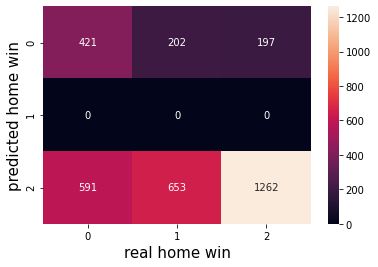

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
cm = confusion_matrix(rf_model_tuned_test,y_test)
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('real home win', fontsize = 15)
plt.ylabel('predicted home win', fontsize = 15)
plt.show()

# PART IV: Model Interpretation

### Feature importance

In [ ]:
def plot_top_features(feature_importance, title, features = X_train_valid.columns, top = 10):
    fig, ax = plt.subplots(figsize = (top, 6))
    top_index = feature_importance.argsort()[::-1][:top]
    plt.bar(range(top),feature_importance[top_index])
    plt.xticks(range(top),features[top_index], rotation = 45)
    plt.title(title)
    plt.show()

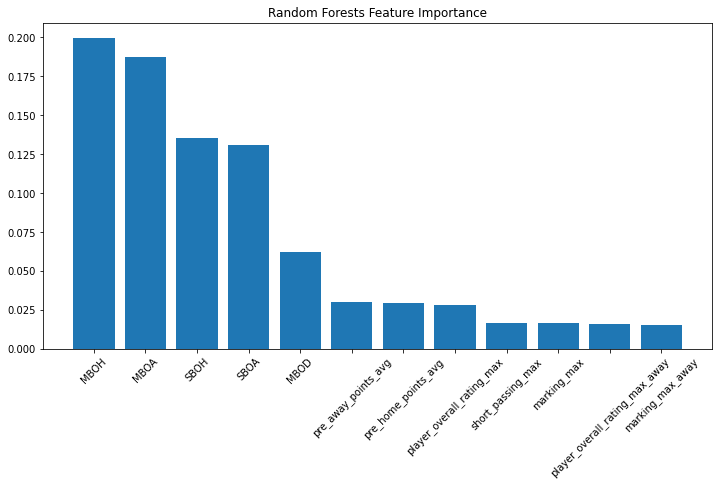

In [ ]:
feature_importances_rf = rf_model_tuned.feature_importances_
plot_top_features(feature_importances_rf, 'Random Forests Feature Importance', top = 12)

### SHAP: features's impacts on testing set

In [ ]:
!pip install shap
import shap

     |████████████████████████████████| 358kB 20.7MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491637 sha256=8978e20365c34d123c20e7f76b94dbed30adbb1993ed05e5fdf06f0213053033
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


In [ ]:
y_test_hat = pd.Series(rf_model_tuned.predict(X_test), index = y_test.index)

In [ ]:
explainer = shap.TreeExplainer(rf_model_tuned,shap.sample(X_train_valid,800))
test_shap=explainer.shap_values(X_test)

100%|===================| 9957/9978 [03:55<00:00]       

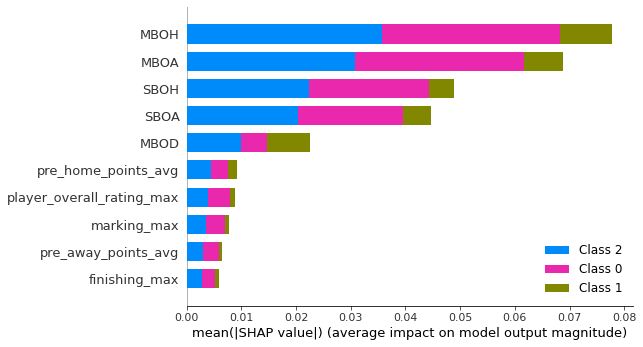

In [ ]:
p=shap.summary_plot(test_shap,X_test,show=False, max_display = 10)

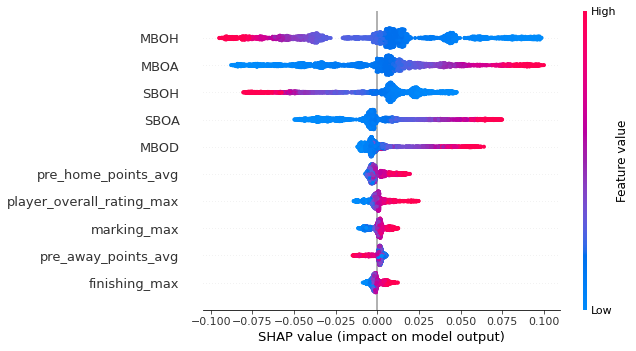

In [ ]:
p = shap.summary_plot(test_shap[2], X_test, max_display = 10)
p

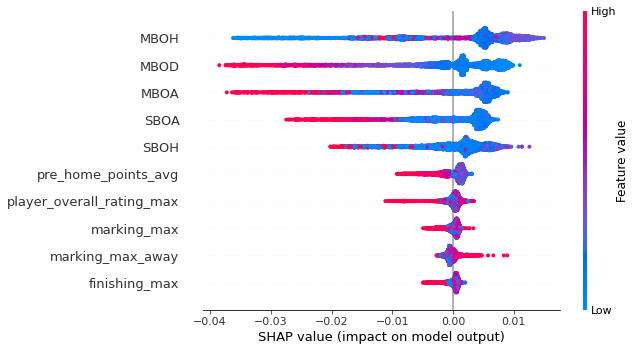

In [ ]:
p = shap.summary_plot(test_shap[1], X_test, max_display = 10)
p

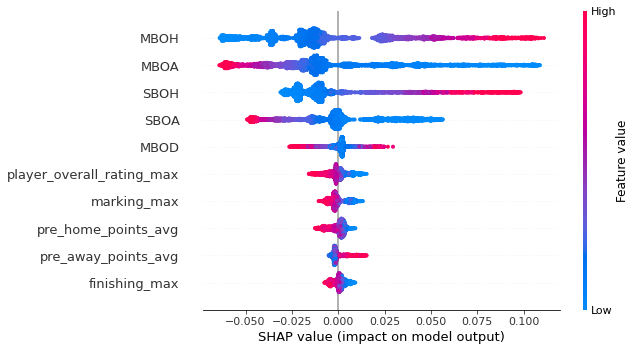

In [ ]:
p = shap.summary_plot(test_shap[0], X_test, max_display = 10)
p

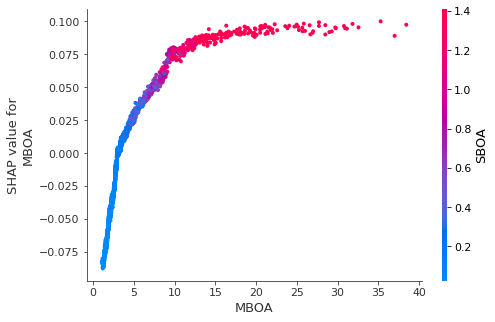

In [ ]:
p = shap.dependence_plot('MBOA', test_shap[2], X_test, interaction_index='SBOA')
p

### SHAP: Features' impacts on one data instance

In [ ]:
Type_Index = 2 # Home_win: 0,1,2
Test_Index = 1 # choose whichever you like

In [ ]:
len(X_rand.columns)

38

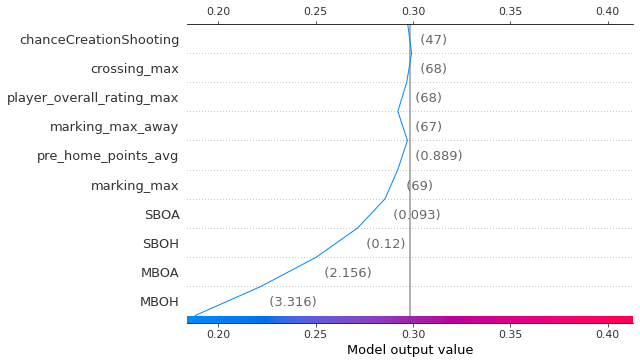

None

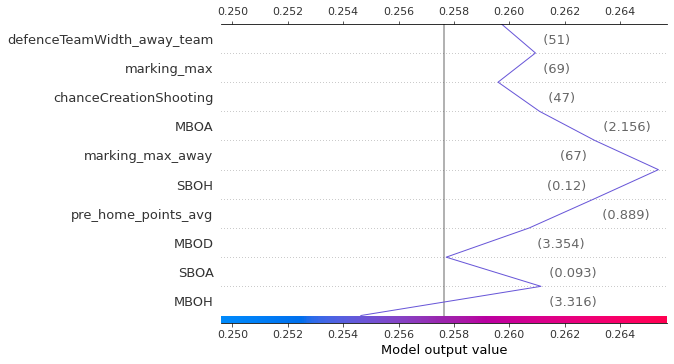

None

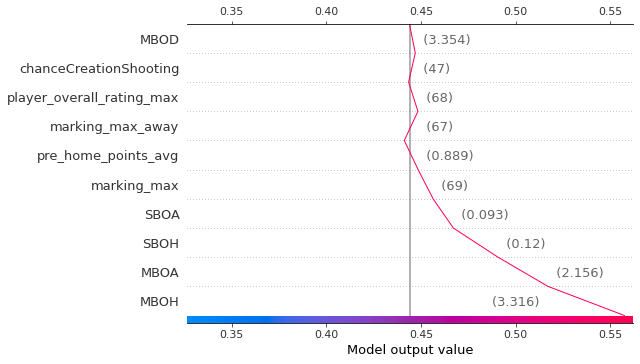

None

In [ ]:
X_rand = X_test.sample(1, random_state=42)
idx = X_rand.index.values[0]

shap_values = explainer.shap_values(X_test.iloc[idx])
shap.initjs()
for which_class in range(0,3):
    display(shap.force_plot(explainer.expected_value[which_class], shap_values[which_class], X_rand))
    display(shap.decision_plot(explainer.expected_value[which_class], shap_values[which_class], X_rand, feature_display_range= range(len(X_rand.columns)-10,len(X_rand.columns))))


#Display all features and SHAP values
# df1=pd.DataFrame(data=[shap_values[0]], columns=X_test.columns, index=[0])
# df2=pd.DataFrame(data=[shap_values[1]], columns=X_test.columns, index=[1])
# df3=pd.DataFrame(data=[shap_values[2]], columns=X_test.columns, index=[2])
# df=pd.concat([df1,df2,df3])
# display(df.transpose())

# Betting Algorithm

In order to asses the long term performance of our predictor, we will compare how a bettor who uses our algorithm to place bets, vs the average bettor which will randomly select a winner (or draw) and bet on it. We will use unit based betting, where a normal confidence bet is 1 unit, and a more confident bet will be 2 units. The majority of gamblers will fall under this perview. Since gambiling is very emotional, we will not deal with bettors who place incredibly large unit bets on single matches for no apparent reason.

## Using the testing set, the average bettor will look at the odds, and place a bet randomly choosing if it will be a home win, loss, and with a lower probability a draw 


Since the odds are given in decimal form, the payout of the bet is amount bet * odds, the winnings are: payout - bet

Since we will be doing all calculations in a unit basesed sense: payout = unit * odds

We will only place a bet if decently confident. Our unit choice scales with confidence. The average bettor will take a similar approach and sit a random amount of bets as well.  Note that the bettor will only poredict a draw with a lowerlikleyhood, as most bettors do 




In [ ]:
X_train = bet_train_df.drop('home_win', axis = 1)
y_train = bet_train_df['home_win']

X_test = test_df.drop('home_win', axis = 1)
y_test = test_df['home_win']

In [ ]:
X_test.head()

,buildUpPlaySpeed,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,buildUpPlaySpeed_away_team,buildUpPlayPassing_away_team,chanceCreationPassing_away_team,chanceCreationCrossing_away_team,chanceCreationShooting_away_team,defencePressure_away_team,defenceAggression_away_team,defenceTeamWidth_away_team,pre_home_points_avg,pre_away_points_avg,player_overall_rating_max,player_overall_rating_std,gk_diving_max,short_passing_max,finishing_max,crossing_max,marking_max,player_overall_rating_max_away,player_overall_rating_std_away,gk_diving_max_away,short_passing_max_away,finishing_max_away,crossing_max_away,marking_max_away,MBOH,MBOA,MBOD,SBOH,SBOA,league_id
105,73.0,50.0,64.0,53.0,36.0,30.0,43.0,62.0,53.0,38.0,66.0,65.0,50.0,43.0,44.0,49.0,1.777778,0.666667,65.0,3.435113,71.0,68.0,68.0,66.0,71.0,65.0,4.771125,68.0,67.0,64.0,76.0,63.0,2.122222,3.422222,3.401429,0.056821,0.172321,15722
106,38.0,38.0,53.0,27.0,66.0,57.0,56.0,49.0,53.0,38.0,66.0,65.0,50.0,43.0,44.0,49.0,1.888889,1.000000,69.0,5.274294,66.0,72.0,69.0,65.0,71.0,65.0,4.771125,68.0,67.0,64.0,76.0,63.0,2.122222,3.422222,3.401429,0.056821,0.172321,15722
107,33.0,51.0,38.0,63.0,48.0,58.0,38.0,52.0,53.0,38.0,66.0,65.0,50.0,43.0,44.0,49.0,1.777778,1.000000,67.0,4.928581,58.0,66.0,62.0,65.0,68.0,65.0,4.468069,68.0,64.0,62.0,76.0,68.0,2.122222,3.422222,3.401429,0.056821,0.172321,15722
108,37.0,38.0,66.0,66.0,33.0,59.0,34.0,64.0,47.0,38.0,61.0,65.0,50.0,43.0,44.0,49.0,1.333333,1.000000,67.0,2.315953,62.0,72.0,62.0,72.0,72.0,68.0,3.202272,71.0,68.0,63.0,77.0,72.0,2.122222,3.422222,3.401429,0.056821,0.172321,15722
109,57.0,40.0,59.0,70.0,67.0,50.0,58.0,45.0,47.0,38.0,61.0,65.0,50.0,43.0,44.0,49.0,1.333333,0.888889,72.0,1.420627,71.0,73.0,72.0,77.0,70.0,68.0,3.202272,71.0,68.0,63.0,77.0,65.0,2.122222,3.422222,3.401429,0.056821,0.172321,15722


In [ ]:
rfmoney = []
bettormoney = []
for run in range(10):
  scaler=StandardScaler()
  scaler.fit_transform(X_train)
  scaler.transform(X_test)
  rf.fit(X_train, y_train)
  rf_pred_train=rf.predict(X_train)
  rf_pred_test=rf.predict(X_test)
  print("In sample accuracy baseline RF with mean bets added: ", accuracy_score(rf_pred_train,y_train))
  print("Out of sample accuracy baseline RF with mean bets added: ", accuracy_score(rf_pred_test,y_test))

  predicted_probs_rf=pd.DataFrame(rf.predict_proba(X_test))
  bet_confidence = predicted_probs_rf.max(axis=1)
  bet_idx = predicted_probs_rf.idxmax(axis=1)
  book_lines = X_test[['MBOH','MBOA','MBOD']]
  bet = np.zeros(len(bet_idx))

  for i in range(len(bet_idx)):
    row = book_lines.iloc[i]
    if bet_idx[i] == 0:
      bet[i] = row[1]
    elif bet_idx[i] == 1:
      bet[i] = row[2]
    else:
      bet[i] = row[0]
  units = 0 
  bettorunits = 0
  for i in range(len(bet)):
    confidence = bet_confidence[i]
    odds = bet[i]
    outcome = y_test.iloc[i]
    prediction = bet_idx[i]
    wager = 0

    bettorlines = book_lines.iloc[i]
    bettorconfidence = np.random.normal()
    bettoraction = np.random.normal()
    bettorwager = 0
    bettorodds = 0
    bettoroutcome = 0
    if bettorconfidence <= .4:
      bettorwager = 0
    elif bettorconfidence <= .6:
      bettorwager = 1
    elif bettorconfidence <= .9:
      bettorwager = 2
    else:
      bettorwager = 3
    if bettoraction <= .2:
      bettorodds = bettorlines[2]
      bettoroutcome = 1
    elif bettoraction <= .6:
      bettorodds = bettorlines[0]
      bettoroutcome = 2
    else:
      bettorodds = bettorlines[1]
      bettoroutcome = 0
    bettorunits = bettorunits - bettorwager
    bettorbet = bettorwager*bettorodds
    if bettoroutcome == outcome:
      bettorunits = bettorunits + bettorbet

    if confidence > .75:
      wager = 1
    if confidence >= .82:
      wager = 2
    if confidence >= .85:
      wager=3
    units = units - wager
    bet_placed = wager*odds
    if outcome == prediction:
      units = units + bet_placed
  
  rfmoney.append(units)
  bettormoney.append(bettorunits)
  print("Trial: {}: Our Model: {} units, Average Bettor: {} units".format(run,units,bettorunits))

In sample accuracy baseline RF with mean bets added:  0.5366176665342339
Out of sample accuracy baseline RF with mean bets added:  0.5075165363800361
Trial: 0: Our Model: 4.884285714285699 units, Average Bettor: -323.01277777777767 units
In sample accuracy baseline RF with mean bets added:  0.536485233743875
Out of sample accuracy baseline RF with mean bets added:  0.5078171978352375
Trial: 1: Our Model: 1.5423809523809402 units, Average Bettor: -331.137857142857 units
In sample accuracy baseline RF with mean bets added:  0.5365735222707809
Out of sample accuracy baseline RF with mean bets added:  0.5087191822008419
Trial: 2: Our Model: 7.097142857142838 units, Average Bettor: -159.87277777777769 units
In sample accuracy baseline RF with mean bets added:  0.5371032534322164
Out of sample accuracy baseline RF with mean bets added:  0.5072158749248347
Trial: 3: Our Model: 6.882857142857126 units, Average Bettor: -199.38277777777802 units
In sample accuracy baseline RF with mean bets adde

In [ ]:
rfmoney = []
bettormoney = []
for run in range(10):
  scaler=StandardScaler()
  scaler.fit_transform(X_train)
  scaler.transform(X_test)
  rf_model_tuned.fit(X_train, y_train)
  rf_pred_train=rf_model_tuned.predict(X_train)
  rf_pred_test=rf_model_tuned.predict(X_test)
  print("In sample accuracy Tuned RF with mean bets added: ", accuracy_score(rf_pred_train,y_train))
  print("Out of sample accuracy Tuned RF with mean bets added: ", accuracy_score(rf_pred_test,y_test))

  predicted_probs_rf=pd.DataFrame(rf_model_tuned.predict_proba(X_test))
  bet_confidence = predicted_probs_rf.max(axis=1)
  bet_idx = predicted_probs_rf.idxmax(axis=1)
  book_lines = X_test[['MBOH','MBOA','MBOD']]
  bet = np.zeros(len(bet_idx))

  for i in range(len(bet_idx)):
    row = book_lines.iloc[i]
    if bet_idx[i] == 0:
      bet[i] = row[1]
    elif bet_idx[i] == 1:
      bet[i] = row[2]
    else:
      bet[i] = row[0]
  units = 0 
  bettorunits = 0
  for i in range(len(bet)):
    confidence = bet_confidence[i]
    odds = bet[i]
    outcome = y_test.iloc[i]
    prediction = bet_idx[i]
    wager = 0

    bettorlines = book_lines.iloc[i]
    bettorconfidence = np.random.normal()
    bettoraction = np.random.normal()
    bettorwager = 0
    bettorodds = 0
    bettoroutcome = 0
    if bettorconfidence <= .4:
      bettorwager = 0
    elif bettorconfidence <= .6:
      bettorwager = 1
    elif bettorconfidence <= .9:
      bettorwager = 2
    else:
      bettorwager = 3
    if bettoraction <= .2:
      bettorodds = bettorlines[2]
      bettoroutcome = 1
    elif bettoraction <= .6:
      bettorodds = bettorlines[0]
      bettoroutcome = 2
    else:
      bettorodds = bettorlines[1]
      bettoroutcome = 0
    bettorunits = bettorunits - bettorwager
    bettorbet = bettorwager*bettorodds
    if bettoroutcome == outcome:
      bettorunits = bettorunits + bettorbet

    if confidence > .75:
      wager = 1
    if confidence >= .82:
      wager = 2
    if confidence >= .85:
      wager=3
    units = units - wager
    bet_placed = wager*odds
    if outcome == prediction:
      units = units + bet_placed
  
  rfmoney.append(units)
  bettormoney.append(bettorunits)
  print("Trial: {}: Our Model: {} units, Average Bettor: {} units".format(run,units,bettorunits))

In sample accuracy Tuned RF with mean bets added:  0.5317617975544078
Out of sample accuracy Tuned RF with mean bets added:  0.5066145520144317
Trial: 0: Our Model: 5.995476190476191 units, Average Bettor: -278.22722222222245 units
In sample accuracy Tuned RF with mean bets added:  0.53149693197369
Out of sample accuracy Tuned RF with mean bets added:  0.5060132291040289
Trial: 1: Our Model: 3.1697619047618932 units, Average Bettor: -166.20412698412719 units
In sample accuracy Tuned RF with mean bets added:  0.5318500860813138
Out of sample accuracy Tuned RF with mean bets added:  0.5063138905592303
Trial: 2: Our Model: 6.1026190476190365 units, Average Bettor: -123.91587301587312 units
In sample accuracy Tuned RF with mean bets added:  0.5317176532909549
Out of sample accuracy Tuned RF with mean bets added:  0.5063138905592303
Trial: 3: Our Model: 8.222619047619036 units, Average Bettor: -201.5974603174604 units
In sample accuracy Tuned RF with mean bets added:  0.5314086434467841
Out

Text(0, 0.5, 'Units')

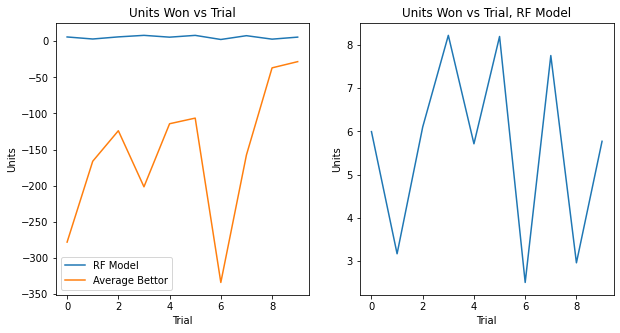

In [ ]:
fig = plt.figure(num=1,clear=True,figsize=(10,5))
ax = plt.subplot(1,2,1)
ax.plot(rfmoney,label = "RF Model")
ax.plot(bettormoney,label = "Average Bettor")
plt.title("Units Won vs Trial")
ax.set_xlabel("Trial")
ax.set_ylabel("Units")
plt.legend()
ax = plt.subplot(1,2,2)
ax.plot(rfmoney,label = "RF Model")
plt.title("Units Won vs Trial, RF Model")
ax.set_xlabel("Trial")
ax.set_ylabel("Units")


In [ ]:
print(np.mean(rfmoney),np.mean(bettormoney),sum(rfmoney),sum(bettormoney))

5.639571428571422 -154.7185000000001 56.39571428571422 -1547.1850000000009
